# Primeira lista de simulações de Dinâmica Estocástica

Autor da resolução: Danilo Lessa Bernardineli (NUSP 8944411)

## Dependências do código

O código neste notebook foi escrito em Python3 (>=3.5.1) e faz o uso das bibliotecas numpy (>=1.12.0), matplotlib (>=2.0.0) e uncertainties (>=3.0.1). Adicionamente foi feito o uso do Jupyter para a elaboração do notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainties as unc
from pylab import rcParams
rcParams['figure.figsize'] = (15, 5) # Ajuste do tamanho das figuras

## Primeira simulação: Estimar $\pi$ e o erro via Monte Carlo para diferentes valores de N

Nesta simulação, obtém-se $\pi$ gerando-se 2N números aleatórios uniformes em $[0, 1]$, na qual se atribui N delas a $x$ e os N restantes a $y$. Feito isso, é feita a contagem M na qual a condição $x^2 + y^2 < 1$ é verdadeira para cada par (x, y) de mesmo índice.

Sabendo-se a contagem, obtém-se $\pi$ através da expressão $\pi \approx \frac{4M}{N}$ enquanto que o erro é obtido pelo desvio padrão de diversas simulações de $\pi$ e usando o fato de que $\sigma_{\pi} \propto \frac{1}{\sqrt{N}}$.

In [2]:
# Funções para calcular o pi via Monte Carlo e o erro através de simulações iteradas

def pi_montecarlo(N=int(1e5), constant=None):
    """Calculates pi by Monte Carlo method using N  pseudo-random (x, y) tuples"""    
    (x, y) = np.random.rand(2, N)
    inds = x ** 2 + y ** 2 <= 1
    M = len(x[inds])
    pi = 4 * M / N
    erro = 1 / np.sqrt(N)
    if constant is None:
        return pi
    else:
        return unc.ufloat(pi, error_pi_montecarlo(N=N, constant=constant))

    
def error_pi_montecarlo(n=int(1e5), N=int(1e3), constant=None):
    """Calculates pi_montecarlo error by getting standard deviation of n simulations
        or by knowing the error constant in advance"""
    if constant is None:
        pis = np.zeros(n)
        for i in range(n):
            pis[i] = pi_montecarlo(N)
        return np.std(pis)
    else:
        return constant / np.sqrt(N)
    
N = int(1e3)
error_constant = error_pi_montecarlo(N) * np.sqrt(N) # Calcular a constante para usar no próximo bloco

In [ ]:
# Calcular o valor de pi e seu erro para diferentes N
for N in 10 ** np.arange(1, 8):
    print("Pi (N:%0.e) %s" % (N, pi_montecarlo(N=N, constant=error_constant)))

### Resultado da simulação

O resultado de uma execução do código acima rendeu a seguinte tabela:

N | $\pi$
:--- | :---
$10^1$ | 3.6(5)
$10^2$ | 3.04(16)
$10^3$ | 3.12(5)
$10^4$ | 3.159(16)
$10^5$ | 3.141(5)
$10^6$ | 3.1417(16)
$10^7$ | 3.1416(5)

## Segunda simulação: Simular a eq. de Langevin

Nessa simulação, é simulada a eq. de Langevin discretizada dada por $v_{l+1} = v_l - \tau \gamma v_l + \sqrt{\tau \Gamma} \xi_l$ onde $\xi_l$ é uma váriavel aleatória com $\langle \xi_l \rangle = 0$ e $\langle \xi_l  \xi_l' \rangle = \delta_{l, l'}$ sendo que em minha resolução, assume-se que $\xi_l = \mathcal{N}(0, 1)$

Assume-se que $\tau = 0.01$, $\gamma = 1$ e $v_0 = 0$ e será feita simulações para tempos suficientemente grandes com diferentes valores de $\Gamma$

In [4]:
# Bloco com a função para simular a eq. de Langevin

def langevin_solve(N=int(1e6), gamma=1, Gamma=None,
                    tau=0.01, epsilon=None):
    """Solves discrete Langevin equation for given parameters"""

    if Gamma is None:
        Gamma = np.array([0.1, 1, 10])

    if epsilon is None:
        epsilon = np.random.randn(N, 1)

    T = np.arange(N) * tau # Elapsed time
    k = np.sqrt(tau * Gamma)

    qtd_Gamma = len(Gamma)
    v = np.zeros((N, qtd_Gamma))

    #Simulação
    for l in range(1, N):
        v[l] = v[l - 1] - tau * gamma * v[l - 1] + k * epsilon[l]
    
    return {"v": v, "t": T, "N": N, "gamma": gamma, "Gamma": Gamma,
            "tau": tau, "epsilon": epsilon}

### Histograma das velocidades

Abaixo, seguem histogramas das velocidades após a simulação da eq. de Langevin

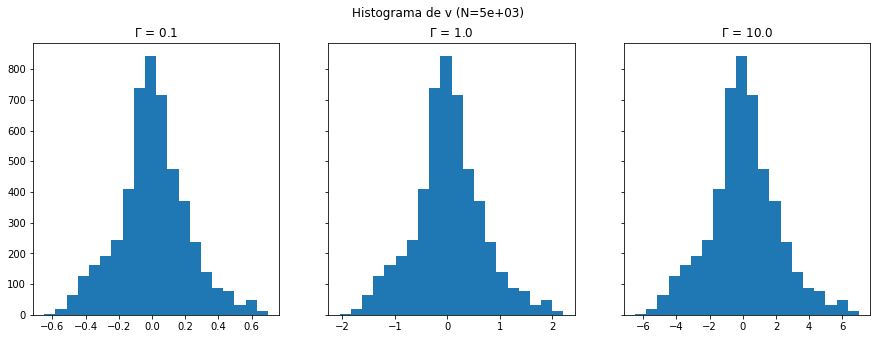

In [5]:
# Simulação da eq. de Langevin para Gamma=[0.1, 1, 10] e N=1e5

N = int(5e3)
langevin_output = langevin_solve(N=N)
qtd_Gamma = langevin_output["v"].shape[1]

f, axarr = plt.subplots(1, qtd_Gamma, sharey=True)
plt.suptitle("Histograma de v (N=%.0e)" % N)
for i in range(qtd_Gamma):
    axarr[i].set_title("$\Gamma$ = %s" % langevin_output["Gamma"][i])
    axarr[i].hist(langevin_output["v"][:, i], bins=20)
f.subplots_adjust(hspace=0.5)
plt.show()

### Correlação entre velocidades

Neste item, será determinada a correlação $C(t) = \langle v(t_0) v(t_0 + t) \rangle$ entre a velocidade no instante $t_0$ e no instante $t$. Será feito um gráfico de $C(t)$ vs $t$ para $t_0$ suficientemente grande.

Para obter $C(t)$, é feita a marginalização em $t_0$ e assume-se P($t_0$) como sendo uma uniforme em todo intervalo de $t_0$.

In [6]:
# Bloco para calcular a correlação dado um t arbitrário e as velocidades simuladas em uma lista t_mtr

def C(t, v, t_mtr):   
    
    N = len(v)    
    i_t = np.argmin(np.abs(t_mtr - t))
    M = N - i_t
    
    termo_1 = v[:M]
    termo_2 = v[-M:]
    C = np.sum(termo_1 * termo_2)
    
    return C

In [7]:
# Calcular a correlação usando a simulação anterior

v = langevin_output["v"][:, 1]
Gamma = langevin_output["Gamma"][1]
N = len(v)
t_mtr = langevin_output["t"]
c = np.zeros(len(t_mtr))
i = 0
for i in range(0, len(t_mtr) - 1):
    t = t_mtr[i]
    c[i] = C(t, v, t_mtr)

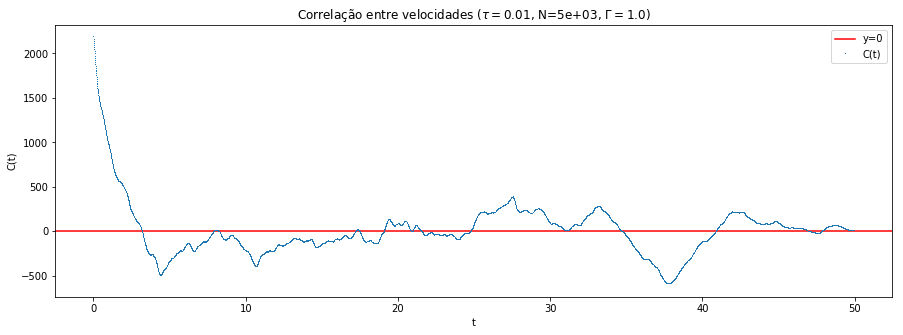

In [8]:
# Exibir o resultado

plt.axhline(0, color="r", label="y=0")
plt.plot(t_mtr, c, ',', label="C(t)")
plt.xlabel("t")
plt.ylabel("C(t)")
plt.title("Correlação entre velocidades ($\\tau=%s$, N=%.0e, $\\Gamma=%s$)" %
          (langevin_output["tau"], N, Gamma))
plt.legend()
plt.show()

## Terceira simulação: Simular a eq. de Langevin com uma função cúbica

Será feita a simulação da eq. de Langevin dada por $\frac{dv}{dt} = f(x) - \gamma v + \zeta (t)$, $f(x) = ax - b x^3$ e $b > 0$ e $a \in \mathbb{R}$. O ruído $\zeta(t)$ segue as propriedades da simulação anterior mas com $\Gamma=1$. O objetivo dessa terceira simulação é fazer histogramas das posições e velocidades para os casos $a > 0$ e $a < 0$

In [9]:
def langevin_cubic_solve(a, b, N=int(1e5), gamma=1, tau=0.01,
                         Gamma=None, epsilon=None):
    """Solves Langevin equation with f(x)=ax-bx³ term for given parameters."""
    if Gamma is None:
        Gamma = 1
    if epsilon is None:
        epsilon = np.random.randn(N, 1)

    T = np.arange(N) * tau # Tempo decorrido
    k = np.sqrt(tau * Gamma)
    v = np.zeros(N)
    x = np.zeros(N)

    #Simulação
    for l in range(1, N):
        x[l] = x[l-1] + v[l-1] * tau
        f = a * x[l] - b * x[l] ** 3
        v[l] = v[l - 1] - tau * gamma * v[l - 1] + k * epsilon[l] + f * tau
        
    return {"v": v, "x": x, "t": T, "N": N, "gamma": gamma,
            "Gamma": Gamma, "tau": tau, "epsilon": epsilon}

### Histogramas no caso $a > 0$ 

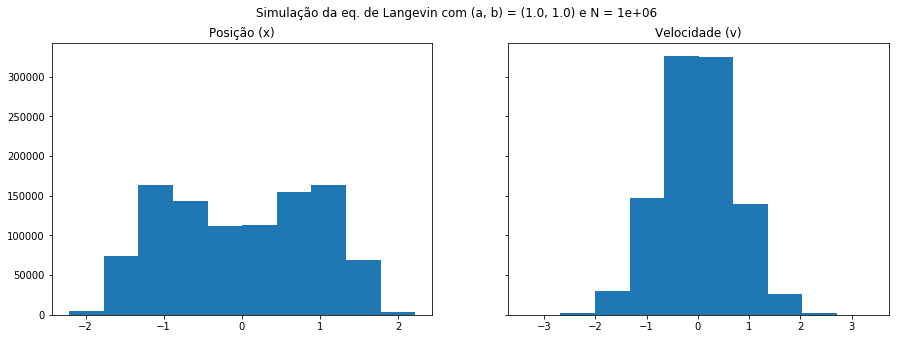

In [10]:
a = 1
b = 1
N = int(1e6)
langevin_output = langevin_cubic_solve(a, b, N=N)
v = langevin_output["v"]
x = langevin_output["x"]
t = langevin_output["t"]

f, axarr = plt.subplots(1, 2, sharey=True)
plt.suptitle("Simulação da eq. de Langevin com (a, b) = (%.1f, %.1f) e N = %.0e" % (a, b, N))
axarr[0].set_title("Posição (x)")
axarr[0].hist(x)
axarr[1].set_title("Velocidade (v)")
axarr[1].hist(v)
f.subplots_adjust(hspace=0.5)
plt.show()

### Histogramas no caso $a <0$ 

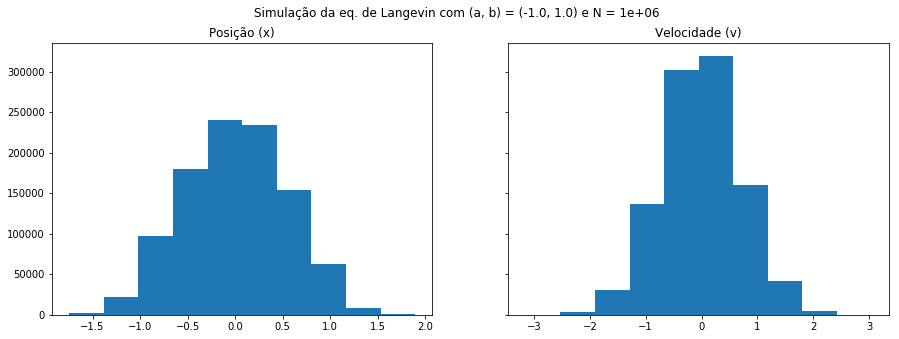

In [11]:
a = -1
b = 1
N = int(1e6)
langevin_output = langevin_cubic_solve(a, b, N=N)
v = langevin_output["v"]
x = langevin_output["x"]
t = langevin_output["t"]

f, axarr = plt.subplots(1, 2, sharey=True)
plt.suptitle("Simulação da eq. de Langevin com (a, b) = (%.1f, %.1f) e N = %.0e" % (a, b, N))
axarr[0].set_title("Posição (x)")
axarr[0].hist(x)
axarr[1].set_title("Velocidade (v)")
axarr[1].hist(v)
f.subplots_adjust(hspace=0.5)
plt.show()

## Links


URL para o notebook original: http://fap.if.usp.br/~danlessa/notebooks/dinestot-1.ipynb